In [69]:
# %%
import os
import sys
sys.path.append('/root/capsule/code/beh_ephys_analysis')
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
import json
from harp.clock import decode_harp_clock, align_timestamps_to_anchor_points
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import re
from utils.beh_functions import parseSessionID, session_dirs
from utils.plot_utils import shiftedColorMap, template_reorder
from open_ephys.analysis import Session##
import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.postprocessing as spost
import spikeinterface.widgets as sw
from aind_dynamic_foraging_basic_analysis.licks.lick_analysis import load_nwb
from aind_ephys_utils import align
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colormaps
from aind_dynamic_foraging_data_utils.nwb_utils import load_nwb_from_filename
from spikeinterface.core.sorting_tools import random_spikes_selection
import pickle
import datetime
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
import spikeinterface.postprocessing as spost
from tqdm import tqdm
import spikeinterface.widgets as sw
%matplotlib inline

In [70]:
plt.close('all')
session = 'behavior_751004_2024-12-20_13-26-11'
data_type = 'curated'
target = 'soma'
session_dir = session_dirs(session)
we = si.load(session_dir['postprocessed_dir_curated'], load_extensions=False)
opto_tbl_file = os.path.join(session_dir['opto_dir_curated'], f'{session}_opto_tagging_metrics.pkl')
opto_tbl = pd.read_pickle(opto_tbl_file)
max_p = [max(curr_resp_p) for curr_resp_p in opto_tbl['resp_p'].tolist()]
min_lat = [min(curr_resp_lat) for curr_resp_lat in opto_tbl['resp_lat'].tolist()]
opto_info = json.load(open(os.path.join(session_dir[f'opto_dir_{data_type}'], f'{session}_opto_info_{target}.json')))
baseline = opto_tbl['firing_rate']*opto_info['resp_win']
baseline[baseline>1] = 1


/opt/conda/lib/python3.10/site-packages/spikeinterface/core/base.py:1109: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.101.2 is recommended
  warnings.warn(


In [71]:
def get_gradient_colors(max_p_values):
    # Normalize values (anything < 0 is mapped to 0)
    norm = mcolors.Normalize(vmin=0, vmax=1)
    
    # Get colormap (Reds gradient)
    cmap = plt.cm.Reds

    # Generate colors based on values
    colors = [cmap(norm(max(0, p))) for p in max_p_values]  # Ensure values < 0 are mapped to black

    return colors

colors = get_gradient_colors(max_p-baseline)


In [73]:
unit_ids = opto_tbl['unit_id'].values.tolist()
unit_ids = [int(unit_id) for unit_id in unit_ids]
# make a dictionary of unit_ids and their corresponding colors
color_dict = dict(zip(unit_ids, colors))

(np.float64(0.9991387927720108),
 np.float64(0.9426989619377163),
 np.float64(0.9153402537485582),
 np.float64(1.0))

In [89]:
unit_ids = pd.Series(unit_ids)  # Ensure unit_ids is a Pandas Series
unit_ids_filtered = unit_ids[~opto_tbl['decoder_label'].isin(['artifact', 'noise'])]


(-100.0, 2000.0)

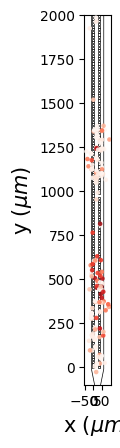

In [76]:
w = sw.plot_unit_locations(we, backend="matplotlib", unit_ids=unit_ids[opto_tbl['decoder_label']!='artifact'], unit_colors=color_dict)
w.ax.set_ylim(-100, 2000)